In [5]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats
from scipy.integrate import quad

# TASK 1

In [6]:
def acquire_data(file_location):
    with open(file_location, 'r') as data_source:
        content_lines = data_source.readlines()

    range_limits = [float(x) for x in content_lines[0].strip().split(' ')]
    frequency_counts = [int(x) for x in content_lines[1].strip().split(' ')]

    return range_limits, frequency_counts

def compute_parameters(frequency_counts, range_limits):
    total_count = sum(frequency_counts)
    data_mean = sum([((x + y) / 2) * z for y, x, z in zip(range_limits[:-1], range_limits[1:], frequency_counts)]) / total_count

    midpoint_values = [(range_limits[i] + range_limits[i+1]) / 2 for i in range(len(range_limits) - 1)]
    deviation_sum = sum(freq * ((mid - data_mean) ** 2) for freq, mid in zip(frequency_counts, midpoint_values))

    variance_estimate = deviation_sum / (total_count - 1)
    standard_deviation = variance_estimate ** 0.5
    significance_level = 0.05  # Default level of significance

    return standard_deviation, data_mean

def manual_specification():
    user_specified_deviation = float(input("Enter the standard deviation (sigma): "))
    return user_specified_deviation

range_limits, frequency_counts = acquire_data('data1.txt')
parameter_source = 0

user_choice = input("Do you want to input the parameters manually or estimate them? (m/e) ")

if user_choice.lower() == 'm':
    sigma = manual_specification()
    data_mean = sum([(x - y) * z for y, x, z in zip(range_limits[:-1], range_limits[1:], frequency_counts)]) / sum(frequency_counts)
else:
    sigma, data_mean = compute_parameters(frequency_counts, range_limits)
    parameter_source = 2
alpha = float(input("Enter the level of significance (alpha): "))

print(f"Intervals: {range_limits}")
print(f"Values: {frequency_counts}")
print(f"Standard deviation (sigma): {round(sigma, 3)}")
print(f"Level of significance (alpha): {alpha}")

Do you want to input the parameters manually or estimate them? (m/e) e
Enter the level of significance (alpha): 0.05
Intervals: [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0]
Values: [2, 24, 136, 470, 868, 864, 469, 143, 23, 1]
Standard deviation (sigma): 0.641
Level of significance (alpha): 0.05


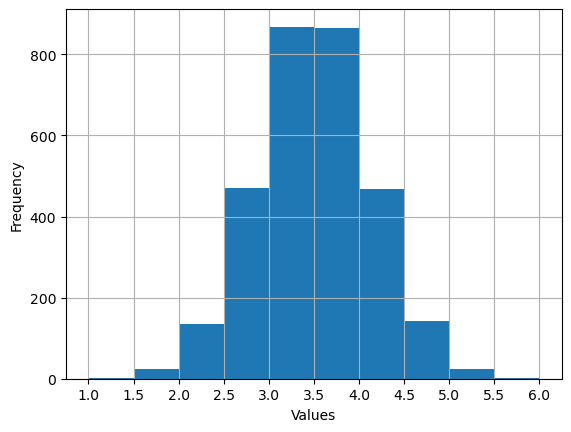

In [7]:
def visualize_distribution(frequency_counts, range_limits):
    fig, canvas = plt.subplots()

    canvas.stairs(frequency_counts, range_limits, fill=True, edgecolor='black')

    canvas.set_xlabel('Values')
    canvas.set_ylabel('Frequency')
    canvas.set_xticks(range_limits)
    canvas.grid(True)

    plt.show()

visualize_distribution(frequency_counts, range_limits)

In [8]:
def compute_normal_cdf(x_value):
    integrand = lambda x: np.exp(-x**2 / 2)
    result, _ = quad(integrand, 0, x_value)
    return (1 / np.sqrt(2 * np.pi)) * result

def obtain_probabilities(range_limits, std_dev, central_value):
    cdf_values = []
    probability_estimates = []

    for i in range(len(range_limits) - 1):
        cdf_values.append(compute_normal_cdf((range_limits[i + 1] - central_value) / std_dev))

    for i in range(len(cdf_values)):
        if i == 0:
            probability_estimates.append(0.5 + cdf_values[i])
        else:
            probability_estimates.append(cdf_values[i] - cdf_values[i - 1])

    probability_estimates[-1] = (1 - sum(probability_estimates[:-1]))

    return probability_estimates

probabilities = obtain_probabilities(range_limits, sigma, data_mean)
print(f"Theoretical probabilities: {probabilities}")

Theoretical probabilities: [0.0008962559092347555, 0.008685048355776381, 0.04955226821342468, 0.15802528572783348, 0.2822185814642164, 0.28254534895846917, 0.15857516680837253, 0.04984031437890546, 0.008755924699471285, 0.0009058054842958629]


In [9]:
def identify_low_frequency(frequency_counts, total_count, probability_estimates):
    for idx, count in enumerate(frequency_counts):
        if count < 5 or total_count * probability_estimates[idx] < 10:
            return idx
    return None

In [10]:
def consolidate_intervals(range_limits, frequency_counts, probability_estimates, total_count):
    while True:
        low_frequency_idx = identify_low_frequency(frequency_counts, total_count, probability_estimates)
        if low_frequency_idx is None:
            break

        elif low_frequency_idx == 0 or low_frequency_idx == 1:
            frequency_counts[low_frequency_idx + 1] += frequency_counts[low_frequency_idx]
            probability_estimates[low_frequency_idx + 1] += probability_estimates[low_frequency_idx]
            frequency_counts.pop(low_frequency_idx)
            probability_estimates.pop(low_frequency_idx)
            range_limits.pop(low_frequency_idx + 1)

        else:
            temp_count = frequency_counts[low_frequency_idx]
            frequency_counts.pop(low_frequency_idx)
            range_limits.pop(low_frequency_idx - 1)
            frequency_counts[low_frequency_idx - 1] += temp_count
            probability_estimates[low_frequency_idx - 1] += probability_estimates[low_frequency_idx]
            probability_estimates.pop(low_frequency_idx)

        if len(frequency_counts) == 1:
            break
    return range_limits, frequency_counts, probability_estimates

range_limits, frequency_counts, probabilities = consolidate_intervals(range_limits, frequency_counts, probabilities, sum(frequency_counts))

print(range_limits)
print(frequency_counts)
print(probabilities)

[1.0, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.5, 6.0]
[26, 136, 470, 868, 864, 469, 143, 24]
[0.009581304265011137, 0.04955226821342468, 0.15802528572783348, 0.2822185814642164, 0.28254534895846917, 0.15857516680837253, 0.04984031437890546, 0.009661730183767148]


In [11]:
def determine_degrees_freedom(num_intervals, parameter_source):
    return num_intervals - parameter_source - 1

def calculate_critical_value(significance_level, degrees_freedom):
    return scipy.stats.chi2.isf(significance_level, degrees_freedom)

def compute_test_statistic(frequency_counts, probability_estimates):
    total_count = sum(frequency_counts)
    test_statistic = 0

    for count, prob in zip(frequency_counts, probability_estimates):
        expected_count = total_count * prob
        test_statistic += ((count - expected_count) ** 2) / expected_count

    return test_statistic

num_intervals = len(range_limits)
degrees_freedom = determine_degrees_freedom(num_intervals - 1, parameter_source)
critical_value = calculate_critical_value(alpha, degrees_freedom)
print(f"Critical value: {critical_value}")
test_statistic = compute_test_statistic(frequency_counts, probabilities)
print(f"Empirical value: {test_statistic}")
if test_statistic > critical_value:
    print("Hypothesis is rejected")
else:
    print("Hypothesis is accepted")

Critical value: 11.070497693516355
Empirical value: 3.465476513589535
Hypothesis is accepted


# TASK 2

In [41]:
def acquire_data(file_location):
    with open(file_location, 'r') as data_source:
        content_lines = data_source.readlines()

    xi = [int(x) for x in content_lines[0].strip().split(' ')]
    ni = [int(x) for x in content_lines[1].strip().split(' ')]

    return xi, ni

def compute_parameters(frequency_counts, range_limits):
    data_mean = sum([x * n for x, n in zip(xi, ni)]) / sum(ni)
    p = data_mean / xi[-1]
    alpha = 0.05
    return p, data_mean

def manual_specification():
    user_specified_deviation = float(input("Enter p: "))
    return user_specified_deviation

xi, ni = acquire_data('data2.txt')
parameter_source = 0

user_choice = input("Do you want to input the parameters manually or estimate them? (m/e) ")

if user_choice.lower() == 'm':
    p = manual_specification()
    data_mean = sum([x * n for x, n in zip(xi, ni)]) / sum(ni)
else:
    p, data_mean = compute_parameters(frequency_counts, range_limits)
    parameter_source = 2
alpha = float(input("Enter the level of significance (alpha): "))
n = xi[-1]
print(f"Xi: {xi}")
print(f"Ni: {ni}")
print(f"P: {p}")
print(f"Xmid: {data_mean}")
print(f"Level of significance (alpha): {alpha}")

Do you want to input the parameters manually or estimate them? (m/e) e
Enter the level of significance (alpha): 0.005
Xi: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Ni: [0, 3, 9, 47, 140, 263, 289, 198, 52]
P: 0.695929070929071
Xmid: 5.567432567432568
Level of significance (alpha): 0.005


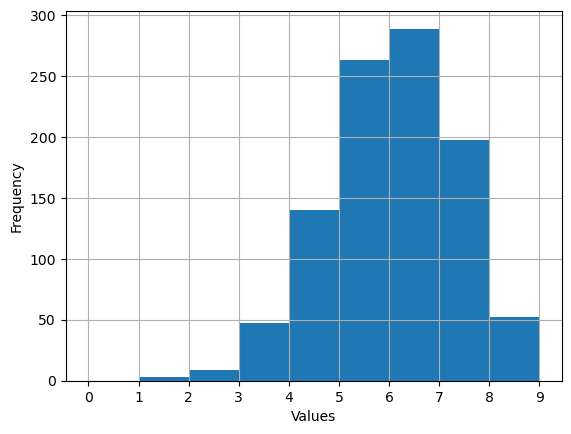

In [42]:
def visualize_distribution(ni, xi):
    fig, canvas = plt.subplots()
    g_xi = xi.copy()
    g_xi.append(g_xi[-1] + 1)
    canvas.stairs(ni, g_xi, fill=True, edgecolor='black')

    canvas.set_xlabel('Values')
    canvas.set_ylabel('Frequency')
    canvas.set_xticks(g_xi)
    canvas.grid(True)

    plt.show()

visualize_distribution(ni, xi)

In [43]:
nCr = lambda n, r : math.factorial(n) / (math.factorial(r) * math.factorial(n - r))
probabilities = []
def p_function(p, i, n):
    return nCr(n, i) * (p ** i) * (1 - p) ** (n - i)
for i in range(len(xi)):
    probabilities.append(p_function(p, i, n))
probabilities[-1] = (1 - sum(probabilities[:-1]))
probabilities

[7.308011273530731e-05,
 0.0013380713536718446,
 0.01071858348626126,
 0.04906338050836469,
 0.14036458910324257,
 0.25700266285745244,
 0.29410181521654677,
 0.19231791331203466,
 0.05501990404969048]

In [44]:
def merge(xi, ni, prob, n):
    while True:
        idx = identify_low_frequency(ni, n, prob)
        if idx is None:
            break
        elif idx == 0:
            ni[idx + 1] += ni[idx]
            prob[idx + 1] += prob[idx]
            ni.pop(idx)
            prob.pop(idx)
            xi.pop(idx)
        else:
            ni[idx - 1] += ni[idx]
            ni.pop(idx)
            prob[idx - 1] += prob[idx]
            xi.pop(idx)
            prob.pop(idx)
            if len(ni) == 1:
                break

merge(xi, ni, probabilities, sum(ni))
print(xi)
print(ni)
print(probabilities)

[2, 3, 4, 5, 6, 7, 8]
[12, 47, 140, 263, 289, 198, 52]
[0.012129734952668413, 0.04906338050836469, 0.14036458910324257, 0.25700266285745244, 0.29410181521654677, 0.19231791331203466, 0.05501990404969048]


In [46]:
degrees_freedom = determine_degrees_freedom(n, parameter_source)
critical_value = calculate_critical_value(alpha, degrees_freedom)
print(f"Critical value: {critical_value}")

test_statistic = compute_test_statistic(ni, probabilities)
print(f"Empirical value: {test_statistic}")
if test_statistic > critical_value:
    print("Hypothesis is rejected")
else:
    print("Hypothesis is accepted")

Critical value: 16.749602343639044
Empirical value: 0.6495489223714641
Hypothesis is accepted
